## Data Download

Unfortunately due to this being a Kaggle competition we cannot download the dataset directly from the competition page, https://www.kaggle.com/competitions/jane-street-real-time-market-data-forecasting/data, I was able to find a reupload of the dataset here, https://www.kaggle.com/datasets/mohamedsameh0410/jane-street-dataset. Download the dataset locally and use SSH to rsync the dataset into the SDSC server.

## Setup Imports and Dataset


In [1]:
import os, pickle, glob
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, mean, stddev, min, max, countDistinct, sum as spark_sum
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import product

Matplotlib created a temporary cache directory at /scratch/brocchio/job_39283482/matplotlib-iuuvw04e because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
sc = SparkSession.builder \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config('spark.executor.instances', 3) \
    .getOrCreate()

## Loading Data

In [3]:
data_path = 'project_data/train.parquet/'
df = sc.read.parquet(data_path)

df.printSchema()

df.show(5)

root
 |-- date_id: short (nullable = true)
 |-- time_id: short (nullable = true)
 |-- symbol_id: byte (nullable = true)
 |-- weight: float (nullable = true)
 |-- feature_00: float (nullable = true)
 |-- feature_01: float (nullable = true)
 |-- feature_02: float (nullable = true)
 |-- feature_03: float (nullable = true)
 |-- feature_04: float (nullable = true)
 |-- feature_05: float (nullable = true)
 |-- feature_06: float (nullable = true)
 |-- feature_07: float (nullable = true)
 |-- feature_08: float (nullable = true)
 |-- feature_09: byte (nullable = true)
 |-- feature_10: byte (nullable = true)
 |-- feature_11: short (nullable = true)
 |-- feature_12: float (nullable = true)
 |-- feature_13: float (nullable = true)
 |-- feature_14: float (nullable = true)
 |-- feature_15: float (nullable = true)
 |-- feature_16: float (nullable = true)
 |-- feature_17: float (nullable = true)
 |-- feature_18: float (nullable = true)
 |-- feature_19: float (nullable = true)
 |-- feature_20: float (n

In [21]:
row_count = df.count()
column_count = len(df.columns)
print(f"The dataset contains {row_count} rows and {column_count} columns.")

The dataset contains 47127338 rows and 93 columns.


## Time, Date, and Symbol ID Analysis

In [4]:
df.select(
    min("date_id").alias("Min Date ID"),
    max("date_id").alias("Max Date ID"),
    countDistinct("date_id").alias("Unique Dates"),
    min("time_id").alias("Min Time ID"),
    max("time_id").alias("Max Time ID"),
    countDistinct("time_id").alias("Unique Time IDs"),
    min("symbol_id").alias("Min Symbol ID"),
    max("symbol_id").alias("Max Symbol ID"),
    countDistinct("symbol_id").alias("Unique Symbols")
).show()

+-----------+-----------+------------+-----------+-----------+---------------+-------------+-------------+--------------+
|Min Date ID|Max Date ID|Unique Dates|Min Time ID|Max Time ID|Unique Time IDs|Min Symbol ID|Max Symbol ID|Unique Symbols|
+-----------+-----------+------------+-----------+-----------+---------------+-------------+-------------+--------------+
|          0|       1698|        1699|          0|        967|            968|            0|           38|            39|
+-----------+-----------+------------+-----------+-----------+---------------+-------------+-------------+--------------+



Here we can see that the time ID has 1699 different values ranging from 1698 to 1699, this represents the date of as trade taking place. There were 39 simulated symbols in this dataset each representing a different stock symbol.

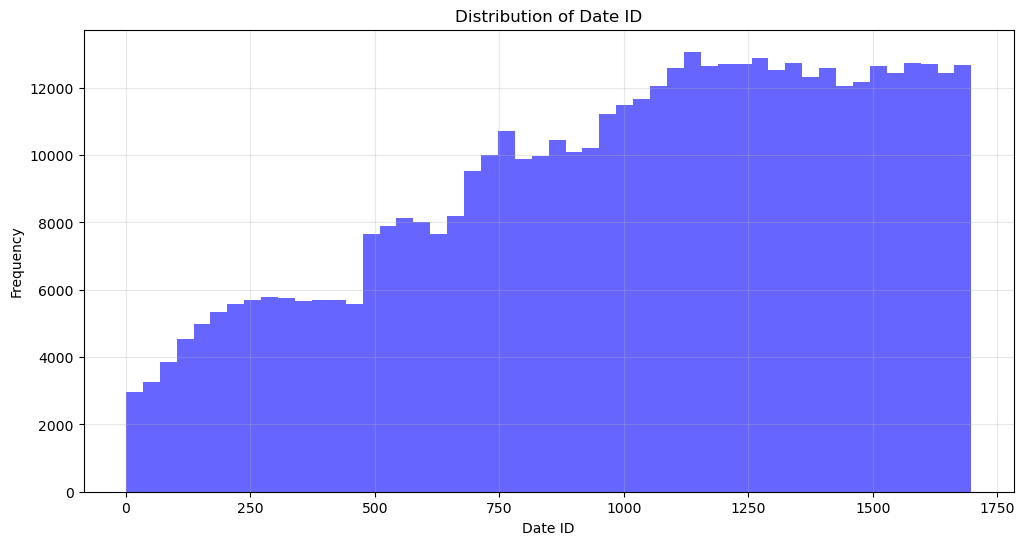

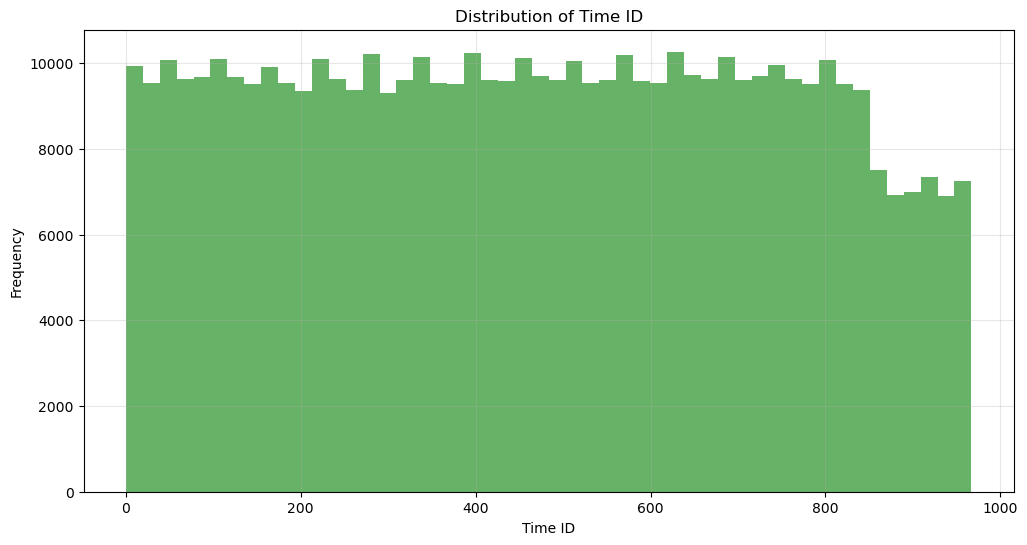

In [5]:
time_data = df.select("date_id", "time_id").sample(fraction=0.01).toPandas()

plt.figure(figsize=(12, 6))
plt.hist(time_data["date_id"], bins=50, color='blue', alpha=0.6)
plt.title("Distribution of Date ID")
plt.xlabel("Date ID")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(time_data["time_id"], bins=50, color='green', alpha=0.6)
plt.title("Distribution of Time ID")
plt.xlabel("Time ID")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

Based on the distributions of the date and time IDs we can see that more trades take place later on in the year with relatively stable frequency of trades throughout the dat with a slight decrease at the end of the day.

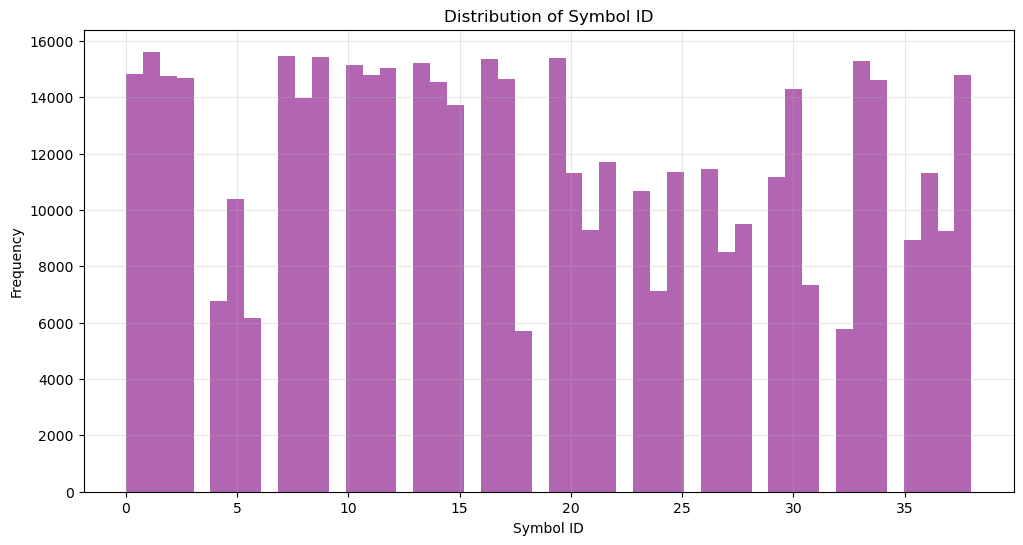

In [6]:
symbol_data = df.select("symbol_id").sample(fraction=0.01).toPandas()

plt.figure(figsize=(12, 6))
plt.hist(symbol_data["symbol_id"], bins=50, color='purple', alpha=0.6)
plt.title("Distribution of Symbol ID")
plt.xlabel("Symbol ID")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

In [7]:
symbol_counts = df.groupBy("symbol_id").count().orderBy(col("count").desc())
symbol_counts.show(10)

+---------+-------+
|symbol_id|  count|
+---------+-------+
|       19|1550501|
|        7|1546272|
|        1|1543979|
|       16|1538290|
|        9|1525333|
|       10|1515692|
|       12|1514621|
|       33|1508099|
|       13|1507964|
|        2|1484398|
+---------+-------+
only showing top 10 rows



In [8]:
symbol_counts = df.groupBy("symbol_id").count()

symbol_counts.select(
    col("symbol_id"),
    col("count")
).orderBy(col("count").desc()).show(5, truncate=False)

symbol_counts.select(
    col("symbol_id"),
    col("count")
).orderBy(col("count").asc()).show(5, truncate=False)

+---------+-------+
|symbol_id|count  |
+---------+-------+
|19       |1550501|
|7        |1546272|
|1        |1543979|
|16       |1538290|
|9        |1525333|
+---------+-------+
only showing top 5 rows

+---------+------+
|symbol_id|count |
+---------+------+
|18       |559504|
|32       |595320|
|6        |611776|
|4        |683408|
|24       |706640|
+---------+------+
only showing top 5 rows



In [9]:
responders = [f"responder_{i}" for i in range(9)]

symbol_variability = df.groupBy("symbol_id").agg(
    *[stddev(col(responder)).alias(f"std_{responder}") for responder in responders]
)

symbol_variability = symbol_variability.withColumn(
    "avg_std", sum([col(f"std_{responder}") for responder in responders]) / len(responders)
).orderBy(col("avg_std").desc())

symbol_variability.show(10)

+---------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|symbol_id|   std_responder_0|   std_responder_1|   std_responder_2|   std_responder_3|   std_responder_4|   std_responder_5|   std_responder_6|   std_responder_7|   std_responder_8|           avg_std|
+---------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|       15|0.8372739763215286| 0.889187143325361|0.7867601392452176|0.9262283587429724| 1.033140737566445|0.7995860476569295|0.9933626332489485|1.0466876165184935|0.9597094167240968|0.9191040077055548|
|       21|0.7900851572907618|0.7603915175754864|0.7892692751162963|0.9196820980908719|0.9716097190020424|0.8118164379182007|1.0169749402495252|1.0505376413152614|0.9710008818325372|0.89792974

Top 10 symbols based on the variance of their responders

## Selecting Top 5 Responders

In [10]:
responder_columns = [f"responder_{i}" for i in range(9)]

stddev_df = df.select(
    *[stddev(col(responder)).alias(f"stddev_{responder}") for responder in responder_columns]
)
missing_df = df.select(
    *[(1 - mean(col(c).isNotNull().cast("double"))).alias(f"missing_{c}") for c in responder_columns]
)

stddev_dict = stddev_df.collect()[0].asDict()
missing_dict = missing_df.collect()[0].asDict()

responder_stats = [
    (responder, stddev_dict[f"stddev_{responder}"], missing_dict[f"missing_{responder}"])
    for responder in responder_columns
]
responder_stats.sort(key=lambda x: x[1], reverse=True)

responder_stats_df = pd.DataFrame(responder_stats, columns=["Responder", "Std Dev", "Missing %"])

responder_stats_df = responder_stats_df.sort_values(by="Std Dev", ascending=False)
print(responder_stats_df)

     Responder   Std Dev  Missing %
0  responder_7  0.916042        0.0
1  responder_6  0.889852        0.0
2  responder_4  0.872840        0.0
3  responder_8  0.864412        0.0
4  responder_3  0.819231        0.0
5  responder_5  0.734546        0.0
6  responder_2  0.599179        0.0
7  responder_0  0.591211        0.0
8  responder_1  0.587551        0.0


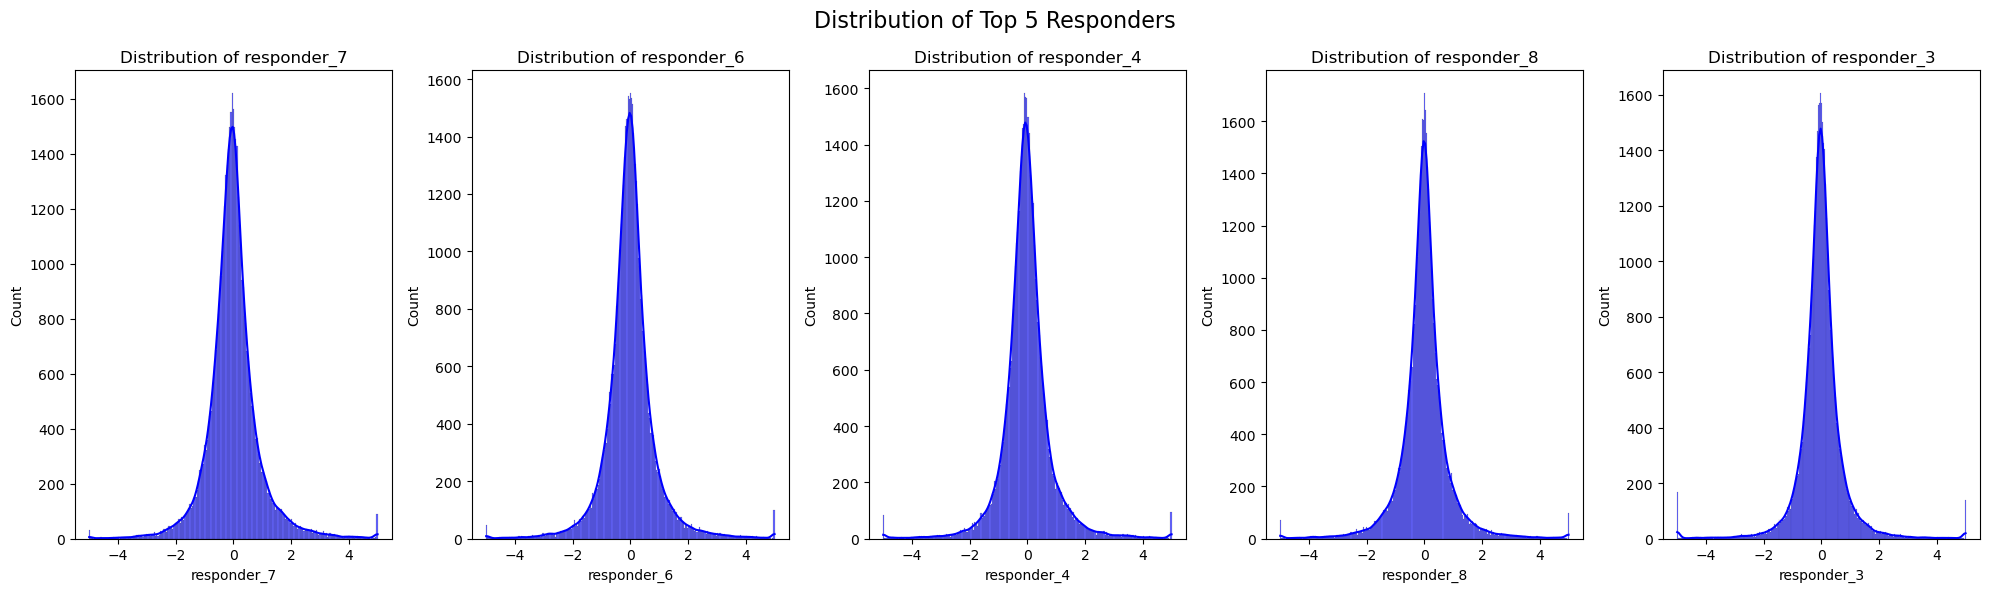

In [11]:
top_5_responders = ["responder_7", "responder_6", "responder_4", "responder_8", "responder_3"]

sample_df = df.sample(fraction=0.001).toPandas()

fig, axes = plt.subplots(1, 5, figsize=(20, 6))
for i, responder in enumerate(top_5_responders):
    sns.histplot(sample_df[responder], kde=True, ax=axes[i], alpha=0.6, color='blue')
    axes[i].set_title(f"Distribution of {responder}")

plt.suptitle("Distribution of Top 5 Responders", fontsize=16)
plt.tight_layout()
plt.show()

## Feature Analysis

In [12]:
feature_columns = [col for col in df.columns if 'responder' not in col]

top_features = {}

for responder in top_5_responders:
    correlations = [(feature, df.corr(feature, responder)) for feature in feature_columns]
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    top_features[responder] = correlations[:10]

for responder, features in top_features.items():
    print(f"Top Features for {responder}:")
    for feature, corr in features:
        print(f"{feature}: {corr:.4f}")
    print("\n")

Top Features for responder_7:
feature_56: -0.0320
feature_45: -0.0303
feature_19: -0.0245
feature_66: -0.0219
feature_06: -0.0219
time_id: -0.0183
feature_08: 0.0160
feature_04: -0.0159
feature_46: -0.0152
feature_57: -0.0149


Top Features for responder_6:
feature_06: -0.0467
feature_04: -0.0305
feature_07: -0.0302
feature_36: -0.0231
feature_60: 0.0189
feature_45: -0.0167
feature_56: -0.0165
feature_05: -0.0163
feature_51: 0.0152
feature_19: -0.0140


Top Features for responder_4:
feature_34: -0.0475
feature_35: -0.0444
feature_36: 0.0409
feature_32: -0.0390
feature_40: 0.0372
feature_61: 0.0333
feature_41: 0.0326
feature_43: 0.0324
feature_49: 0.0267
feature_33: 0.0262


Top Features for responder_8:
feature_06: -0.0851
feature_07: -0.0528
feature_04: -0.0283
feature_36: -0.0261
feature_05: -0.0254
feature_51: 0.0188
feature_68: 0.0164
feature_60: 0.0143
feature_54: 0.0120
feature_59: 0.0116


Top Features for responder_3:
feature_34: -0.0693
feature_36: 0.0645
feature_35: -0.0645
f

In [13]:
selected_features = [
    "feature_06", "feature_04", "feature_36", "feature_34", "feature_35",
    "feature_32", "feature_40", "feature_43", "feature_49", "feature_61"
]

selected_responders = ["responder_7", "responder_6", "responder_4", "responder_8", "responder_3"]

selected_columns = selected_features + selected_responders

df_filtered = df.select(selected_columns)

print(f"Number of rows: {df_filtered.count()}")
print(f"Number of columns: {len(df_filtered.columns)}")

Number of rows: 47127338
Number of columns: 15


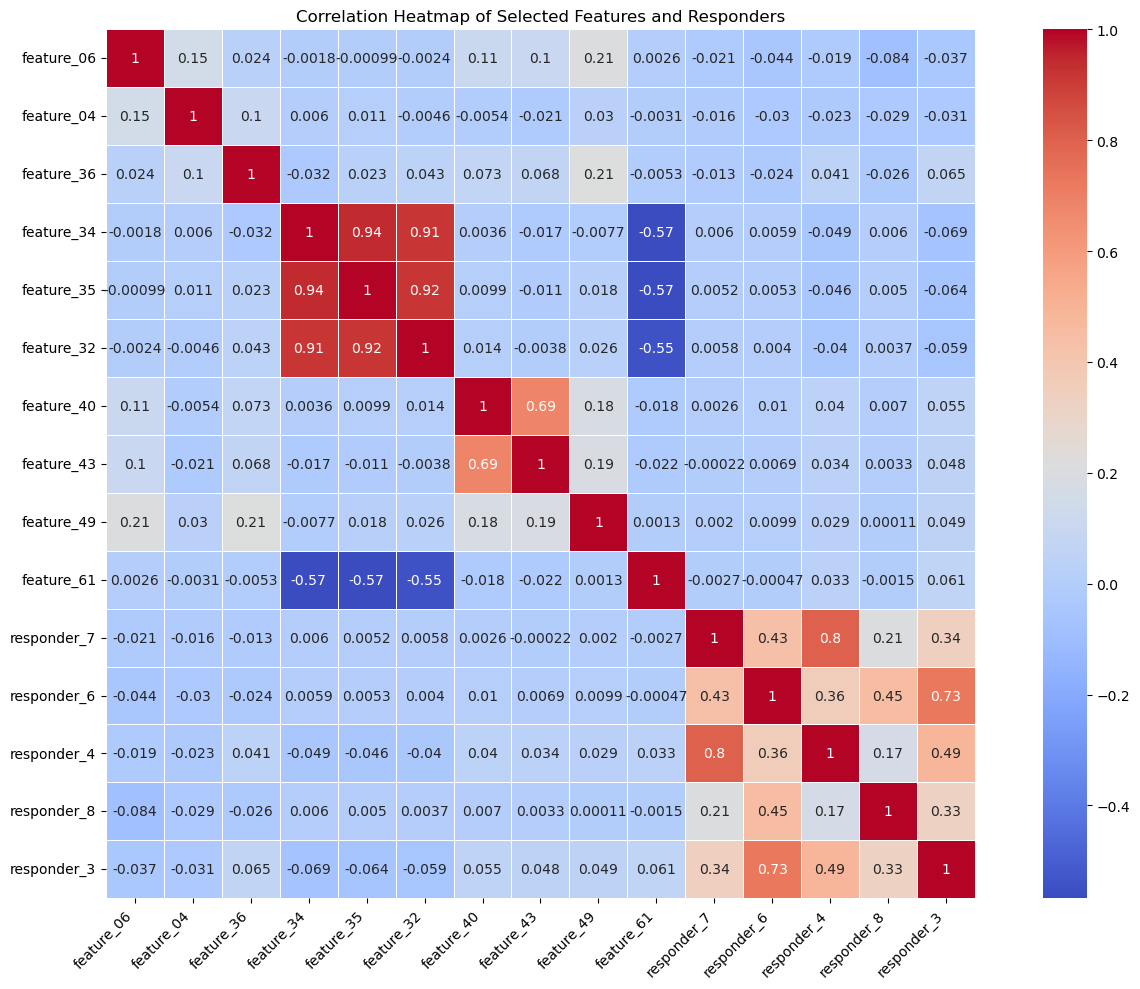

In [14]:
sample_df = df_filtered.sample(fraction=0.01).toPandas()  # Adjust sample size for plotting

correlation_matrix = sample_df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True, square=True, linewidths=0.5)
plt.title("Correlation Heatmap of Selected Features and Responders")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

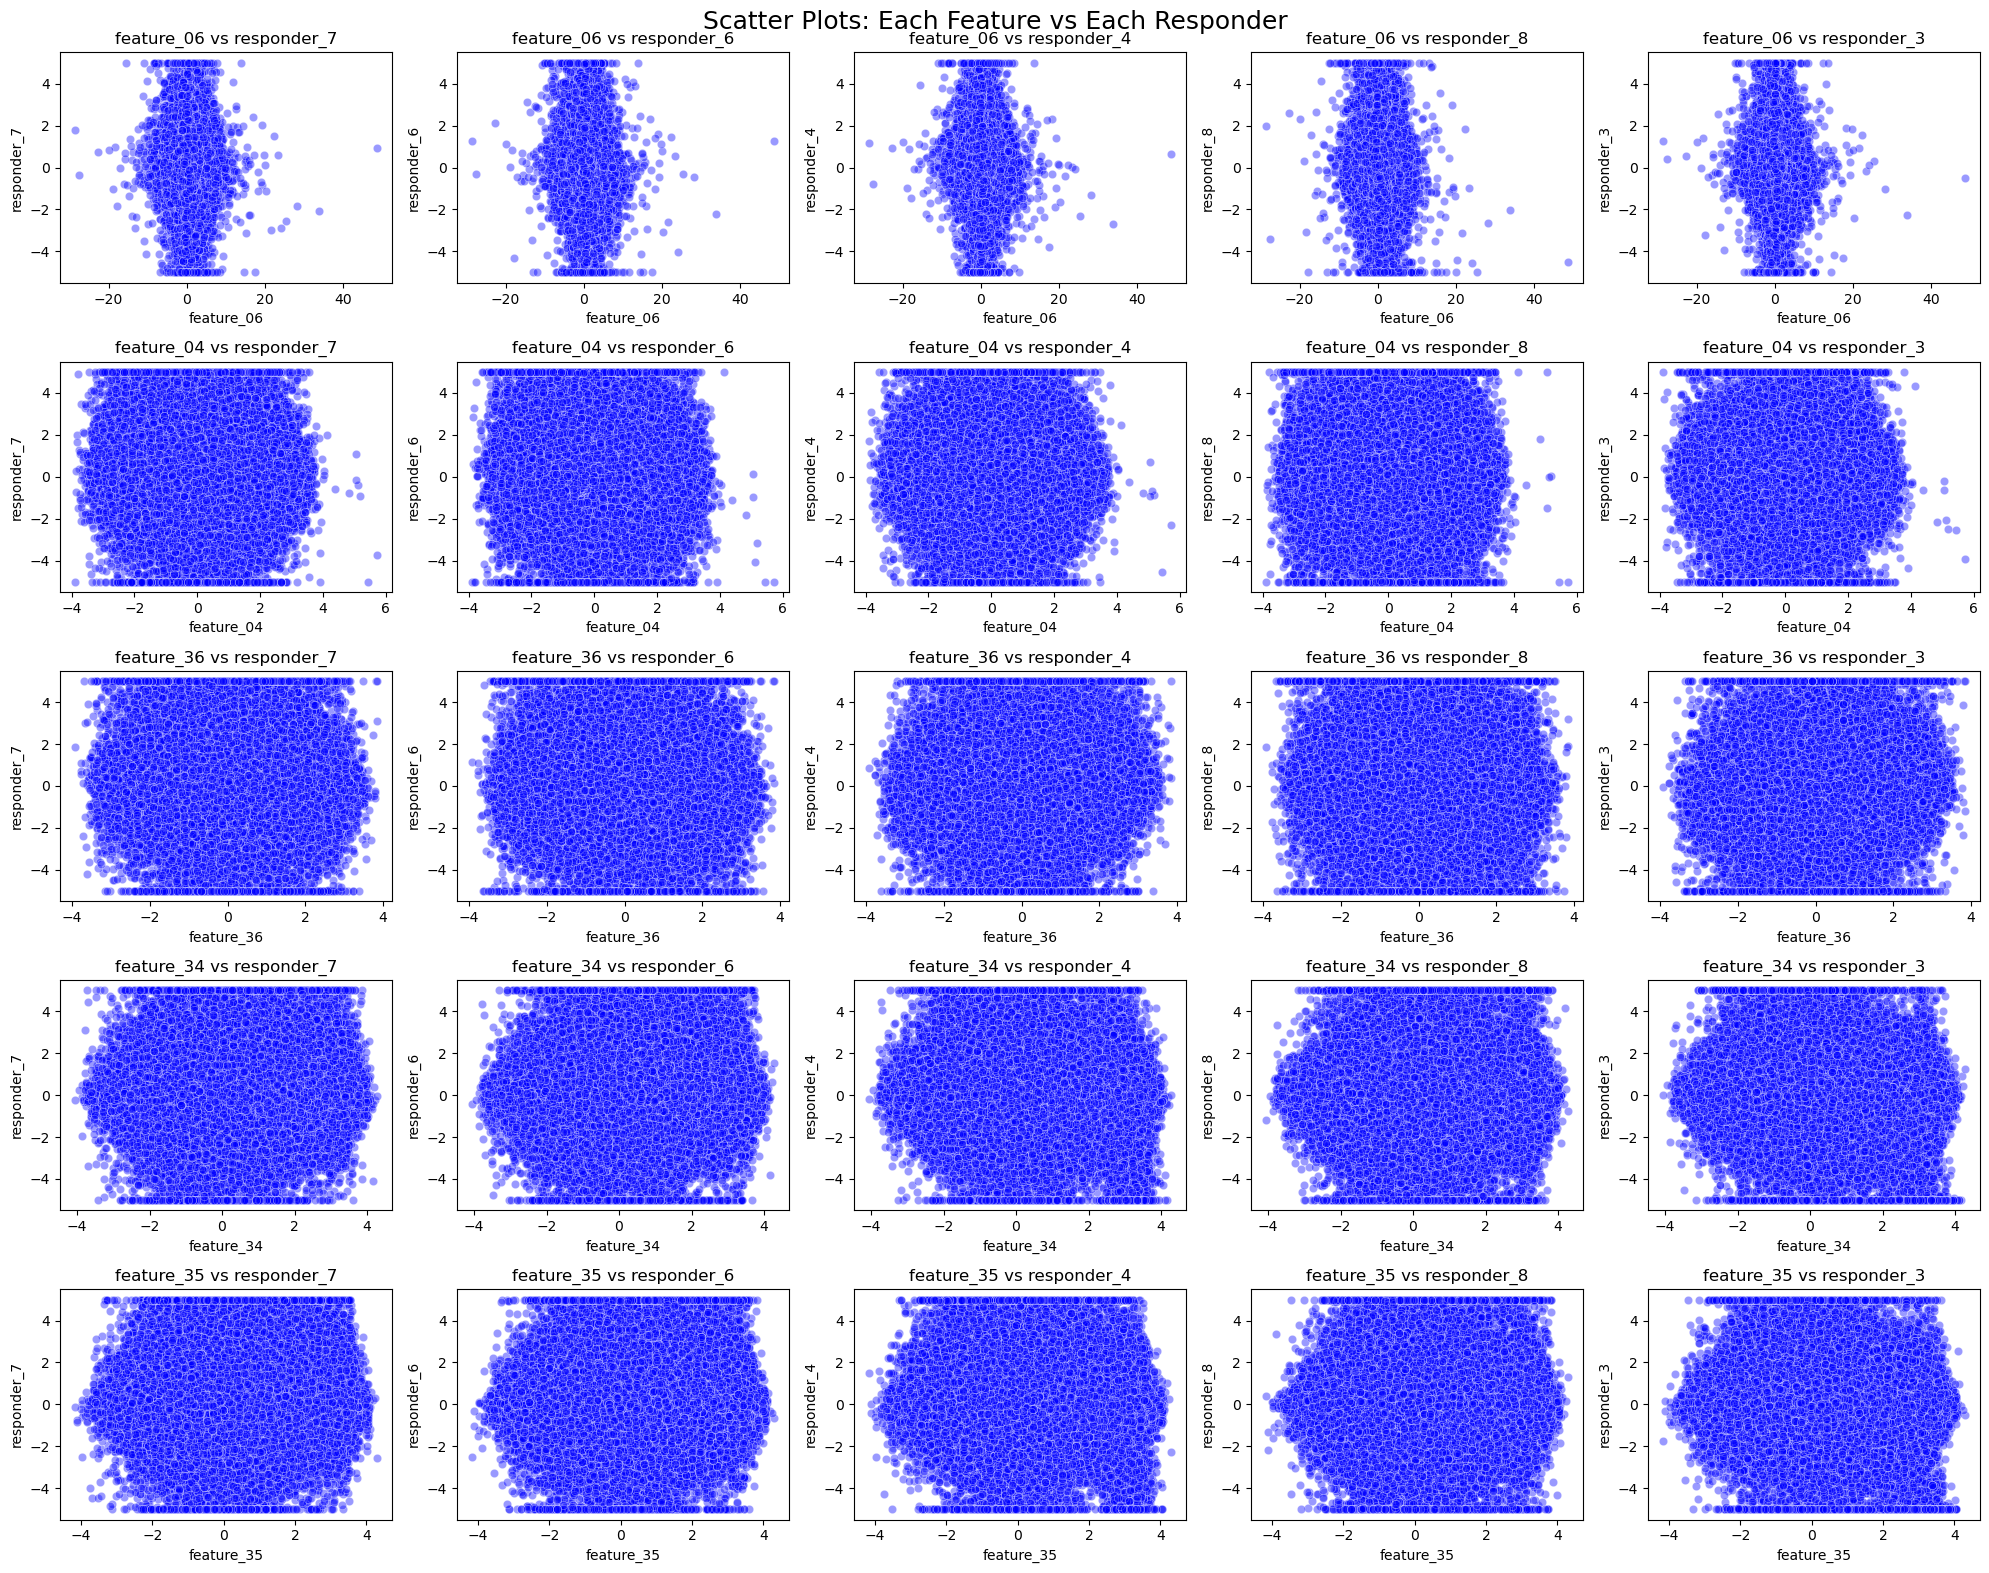

In [15]:
sample_df = df.sample(fraction=0.01).toPandas()

features = ["feature_06", "feature_04", "feature_36", "feature_34", "feature_35"]
responders = ["responder_7", "responder_6", "responder_4", "responder_8", "responder_3"]

plot_pairs = list(product(features, responders))

n_rows = len(features)
n_cols = len(responders)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 16))
axes = axes.flatten()

for i, (feature, responder) in enumerate(plot_pairs):
    sns.scatterplot(data=sample_df, x=feature, y=responder, alpha=0.4, ax=axes[i], color='blue')
    axes[i].set_title(f"{feature} vs {responder}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel(responder)

plt.suptitle("Scatter Plots: Each Feature vs Each Responder", fontsize=18)
plt.tight_layout()
plt.show()

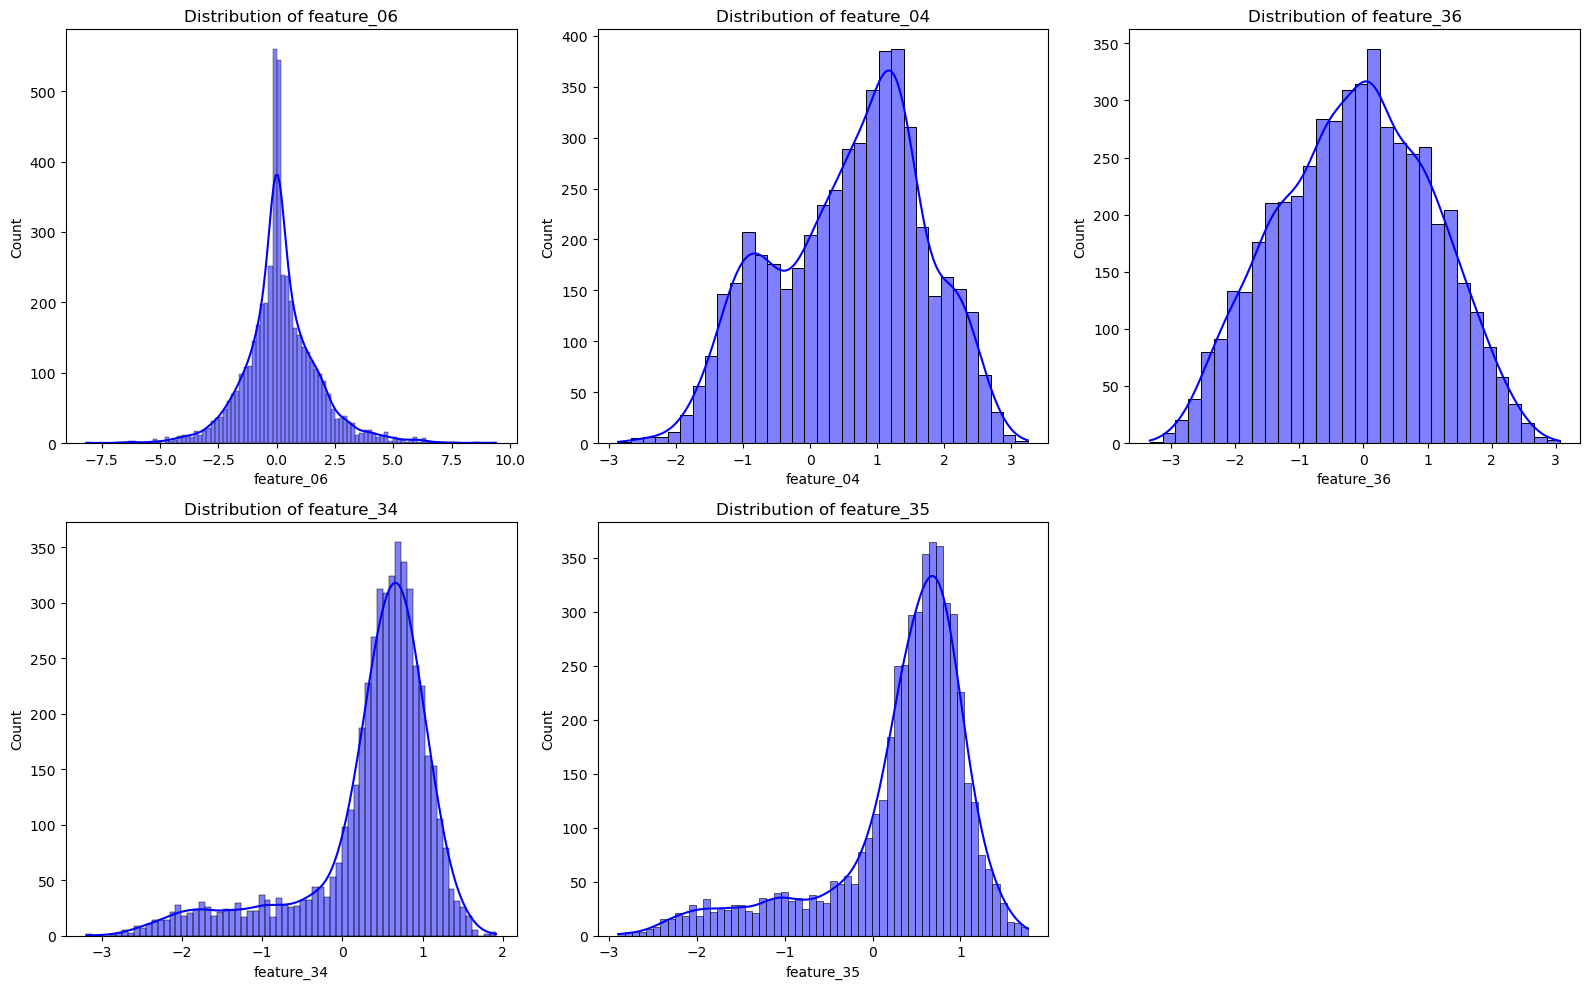

In [16]:
sample_df = df.limit(5000).toPandas()

selected_features = ['feature_06', 'feature_04', 'feature_36', 'feature_34', 'feature_35']

plt.figure(figsize=(16, 10))
for i, feature in enumerate(selected_features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(sample_df[feature], kde=True, color='blue')
    plt.title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()

        column  missing_percentage
25  feature_21           17.900406
30  feature_26           17.900406
31  feature_27           17.900406
35  feature_31           17.900406
43  feature_39            9.125593
46  feature_42            9.125593
57  feature_53            9.026816
54  feature_50            9.026816
4   feature_00            6.752030
6   feature_02            6.752030


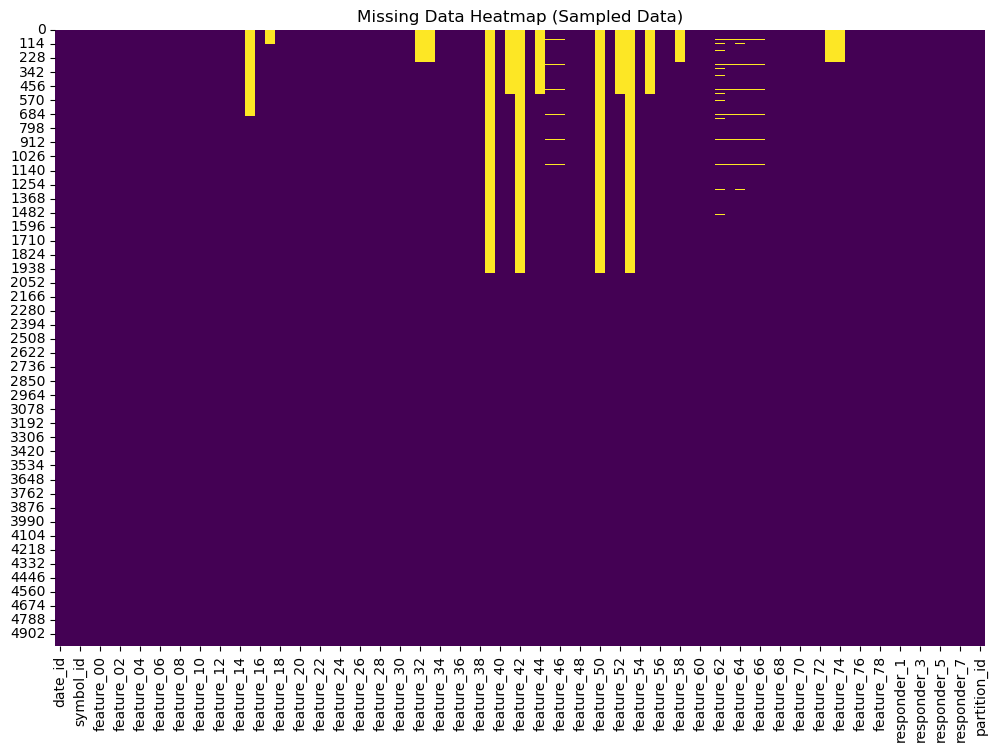

In [17]:
total_rows = df.count()

missing_data_spark = df.select([
    (spark_sum(col(c).isNull().cast("int")) / total_rows).alias(c) for c in df.columns
])

missing_data_pd = missing_data_spark.toPandas().T.reset_index()
missing_data_pd.columns = ['column', 'missing_percentage']
missing_data_pd['missing_percentage'] = missing_data_pd['missing_percentage'] * 100

missing_data_pd = missing_data_pd[missing_data_pd['missing_percentage'] > 0]
missing_data_pd = missing_data_pd.sort_values(by='missing_percentage', ascending=False).head(10)

print(missing_data_pd)

sample_df = df.limit(5000).toPandas()

plt.figure(figsize=(12, 8))
sns.heatmap(sample_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Heatmap (Sampled Data)")
plt.show()

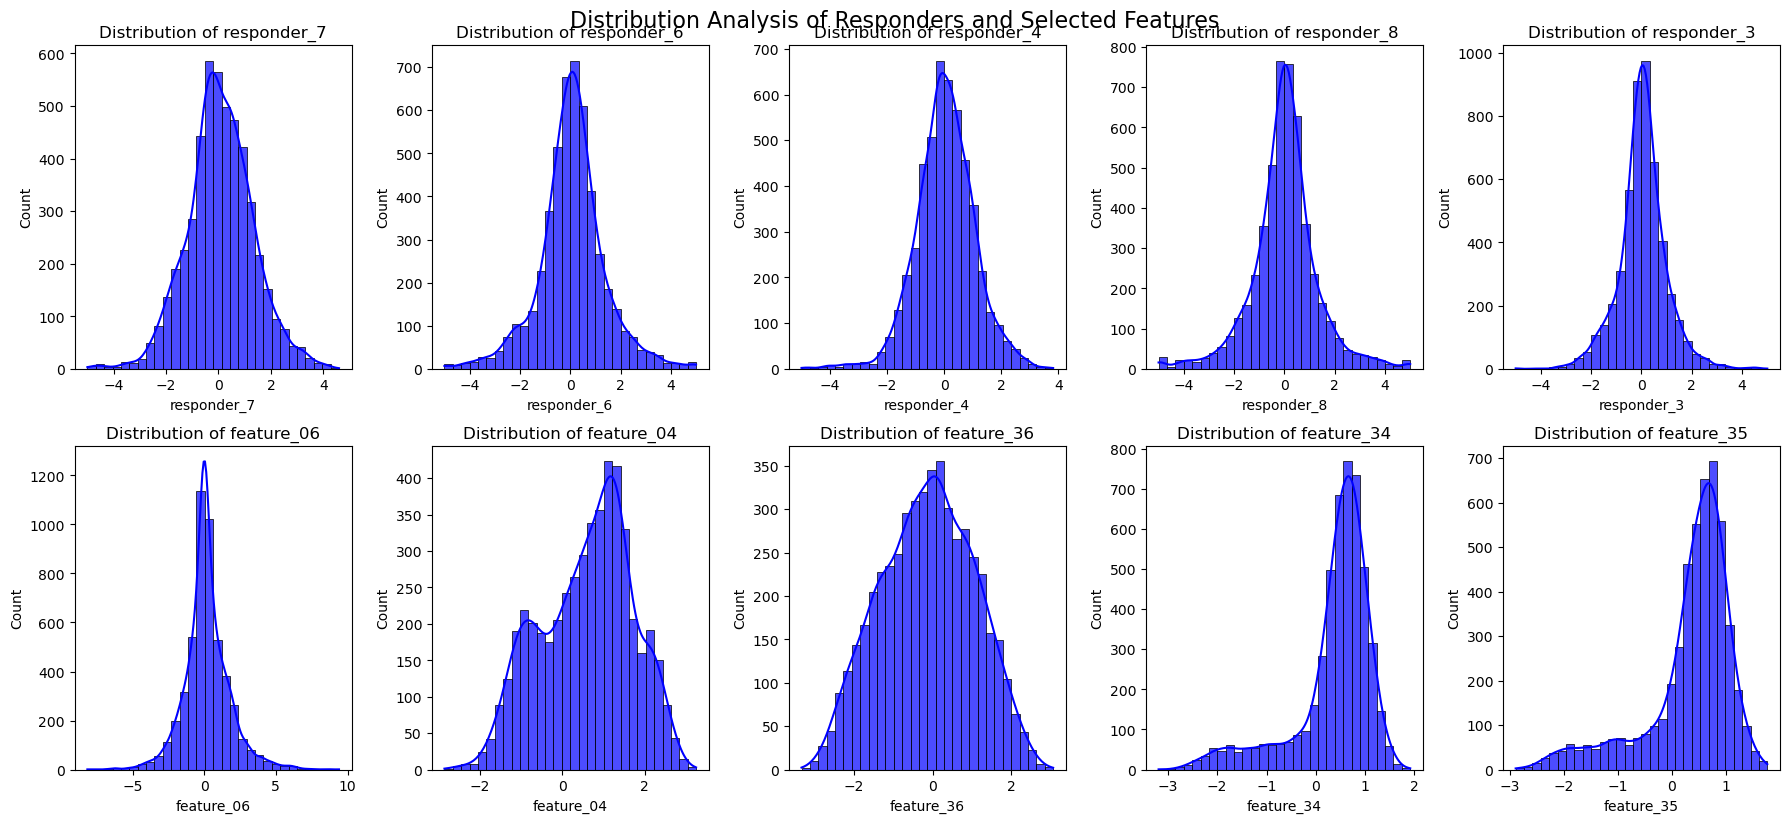

In [18]:
sample_df = df.limit(5000).toPandas()

responders = ['responder_7', 'responder_6', 'responder_4', 'responder_8', 'responder_3']
selected_features = ['feature_06', 'feature_04', 'feature_36', 'feature_34', 'feature_35']

plt.figure(figsize=(18, 12))
for i, col in enumerate(responders + selected_features):
    plt.subplot(3, 5, i + 1)
    sns.histplot(sample_df[col], kde=True, color='blue', alpha=0.7, bins=30)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.suptitle("Distribution Analysis of Responders and Selected Features", fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()

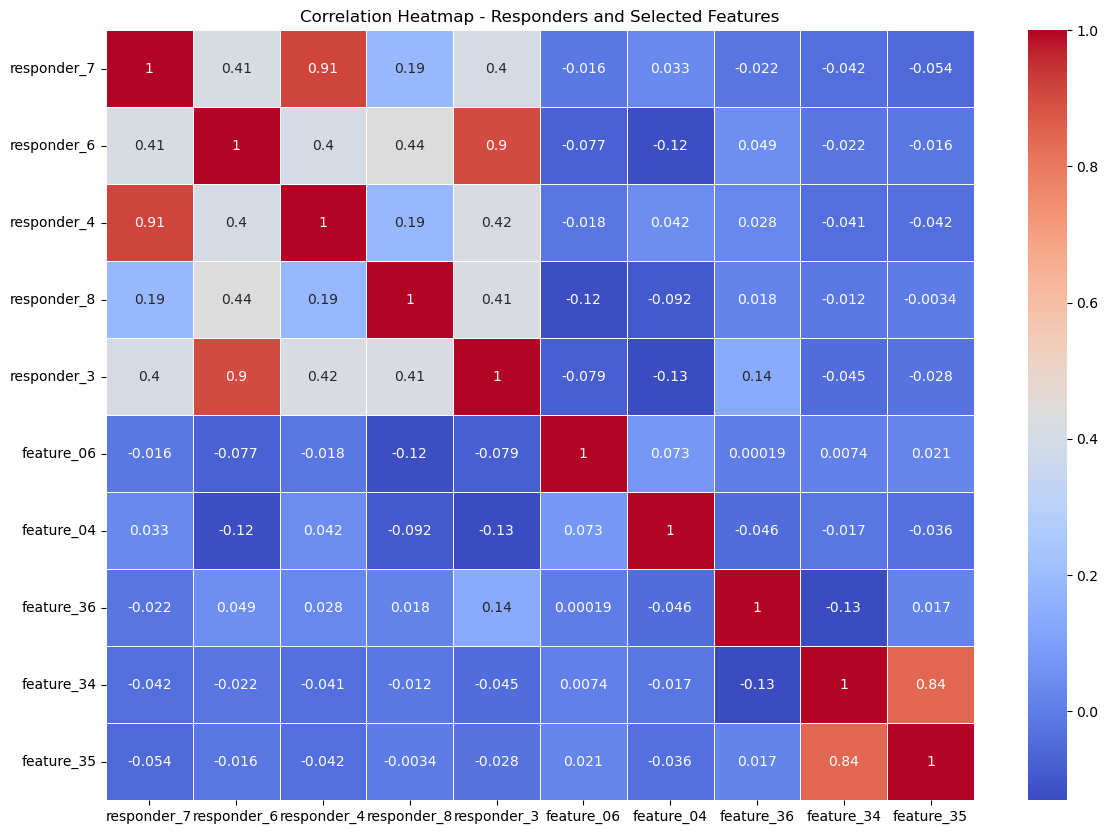

In [19]:
corr_df = sample_df[responders + selected_features]
corr_matrix = corr_df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title("Correlation Heatmap - Responders and Selected Features")
plt.show()


## Time Series Analysis

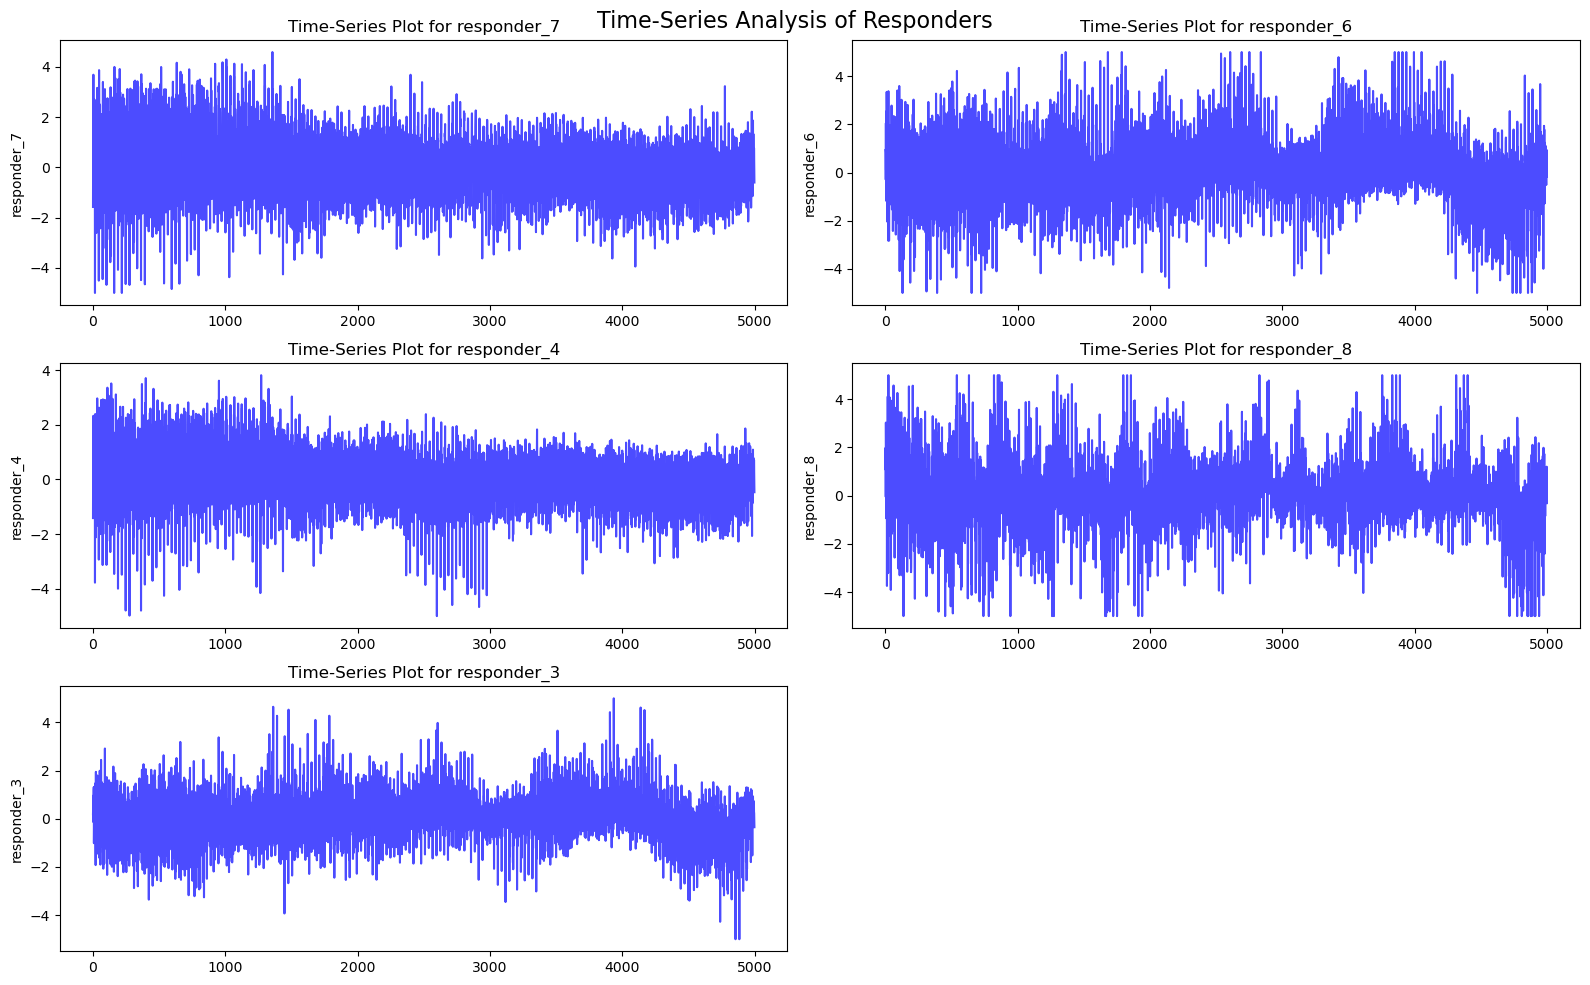

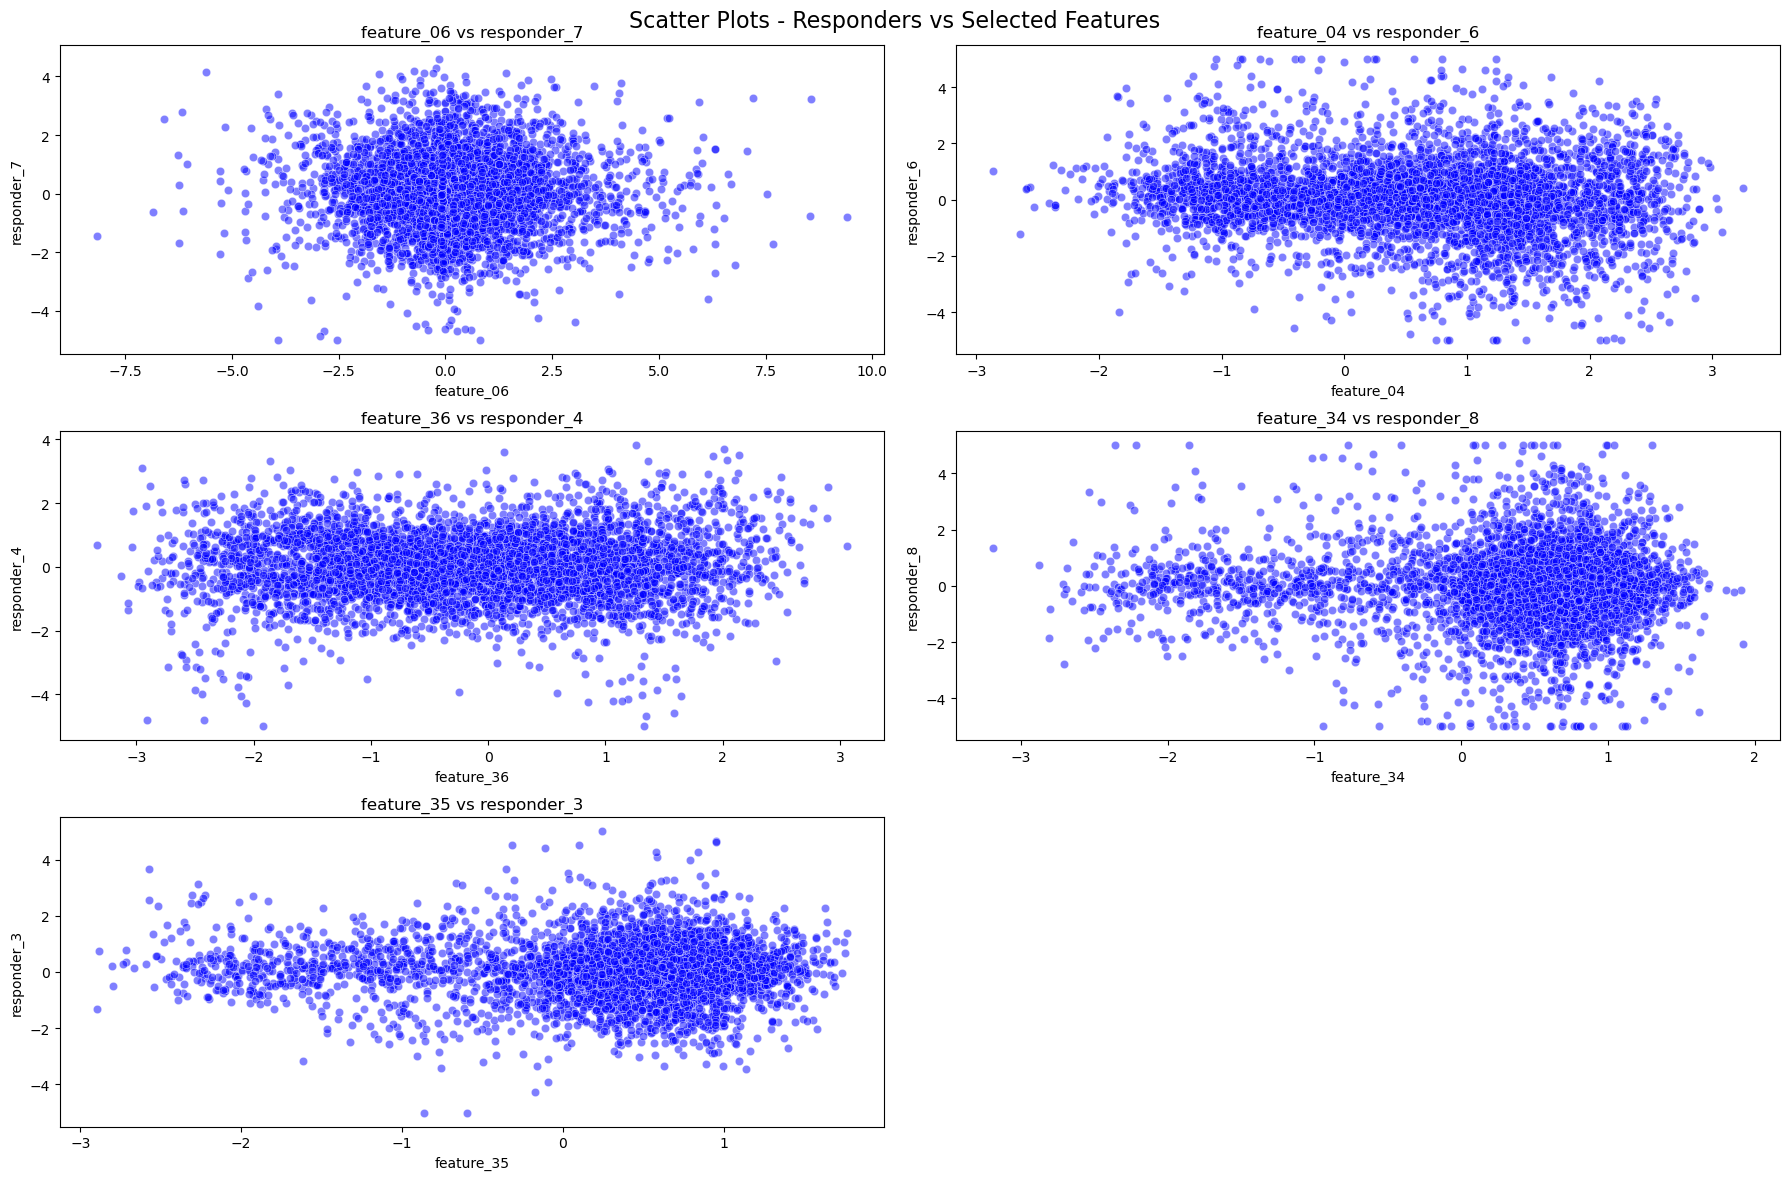

In [20]:
plt.figure(figsize=(16, 10))
for i, responder in enumerate(responders):
    plt.subplot(3, 2, i + 1)
    sns.lineplot(data=sample_df, x=np.arange(len(sample_df)), y=responder, alpha=0.7, color='blue')
    plt.title(f"Time-Series Plot for {responder}")
plt.tight_layout()
plt.suptitle("Time-Series Analysis of Responders", fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()

plt.figure(figsize=(18, 12))
for i, (responder, feature) in enumerate(zip(responders, selected_features)):
    plt.subplot(3, 2, i + 1)
    sns.scatterplot(data=sample_df, x=feature, y=responder, alpha=0.5, color='blue')
    plt.title(f"{feature} vs {responder}")
plt.tight_layout()
plt.suptitle("Scatter Plots - Responders vs Selected Features", fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()